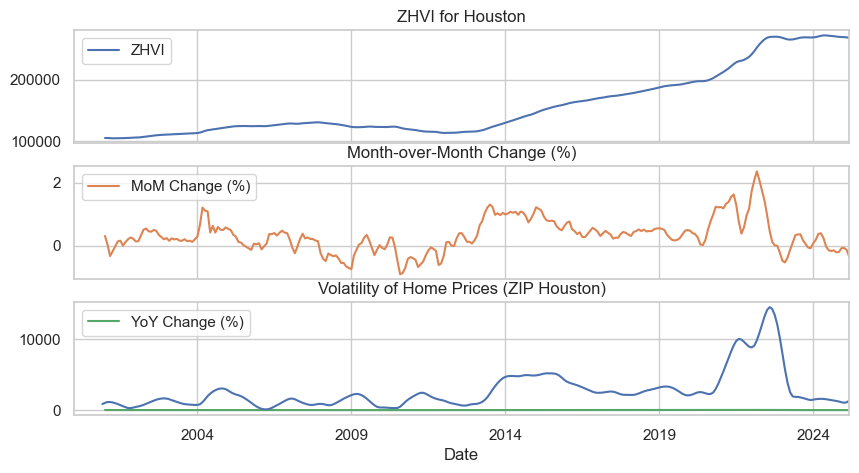

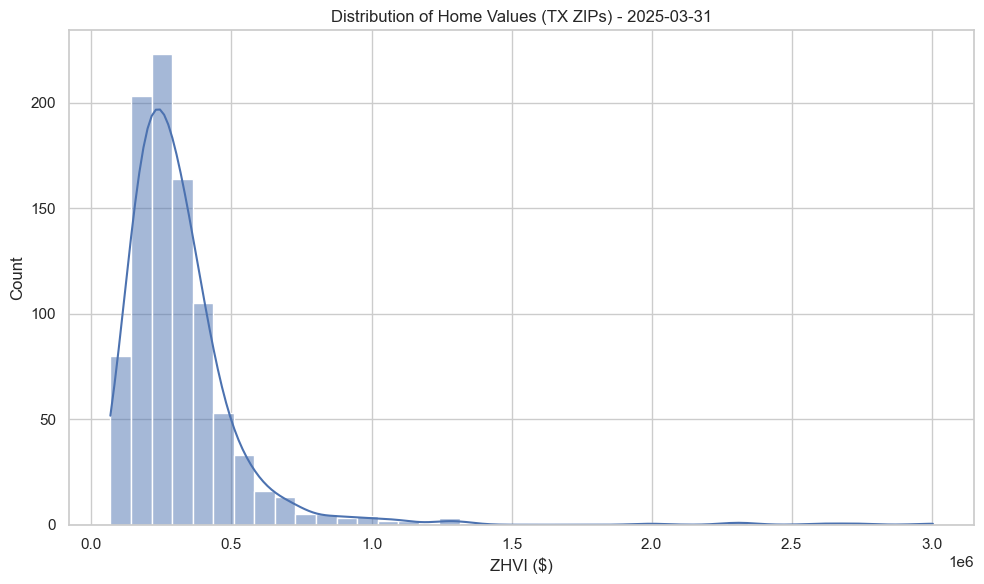

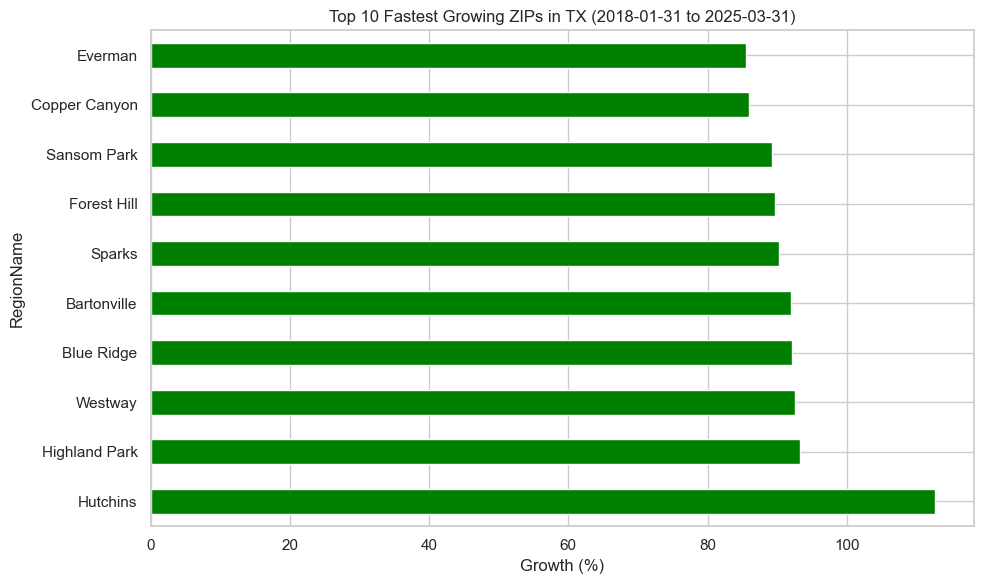

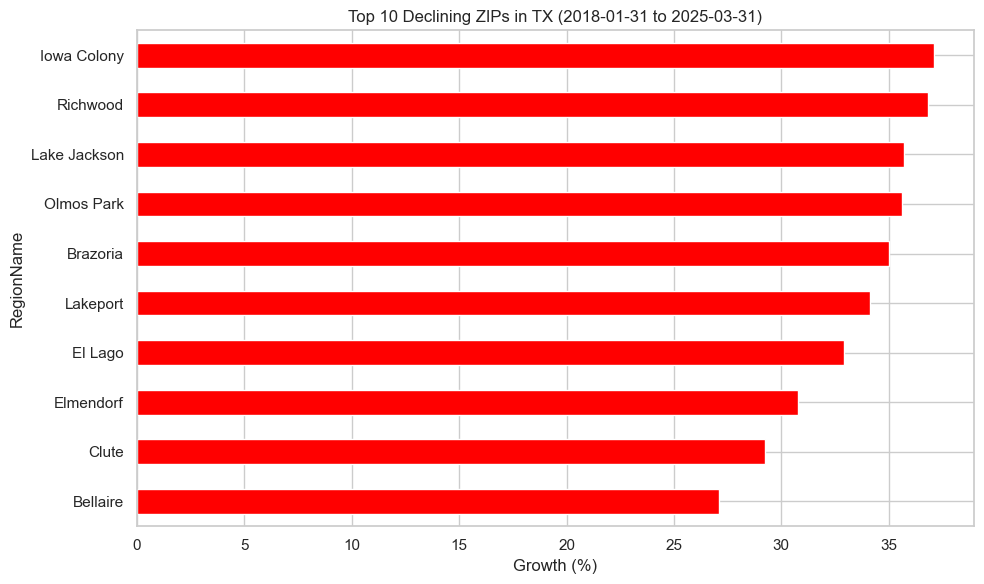

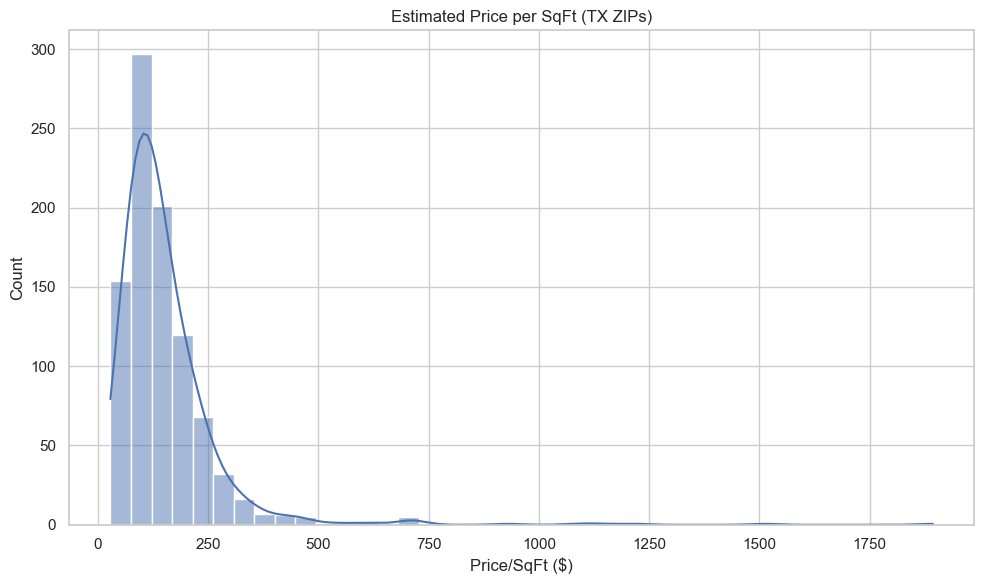

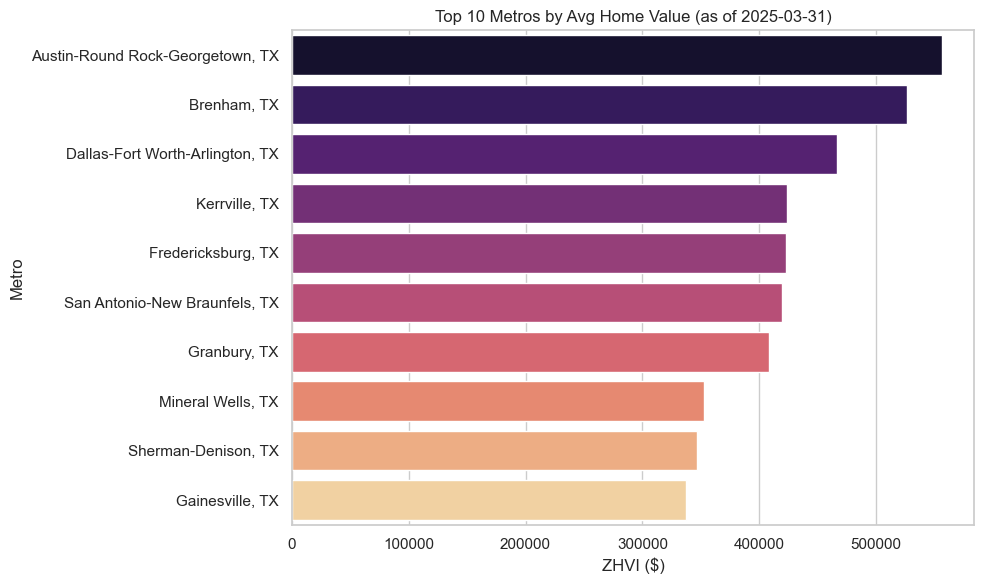

Linear Regression R²: 0.9307322958004869
RMSE: 54004.891976995714
MAE: 25117.17853453658


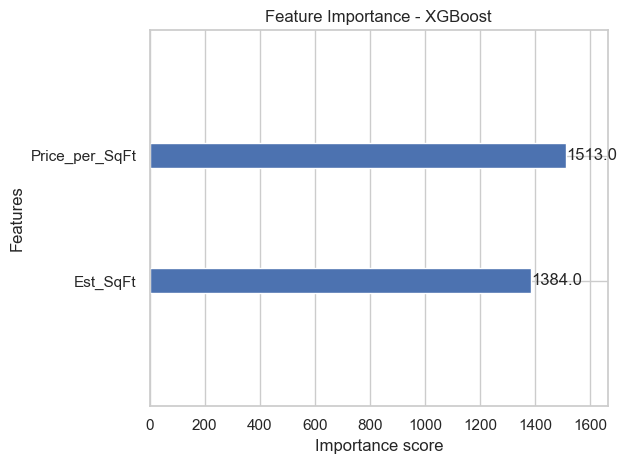

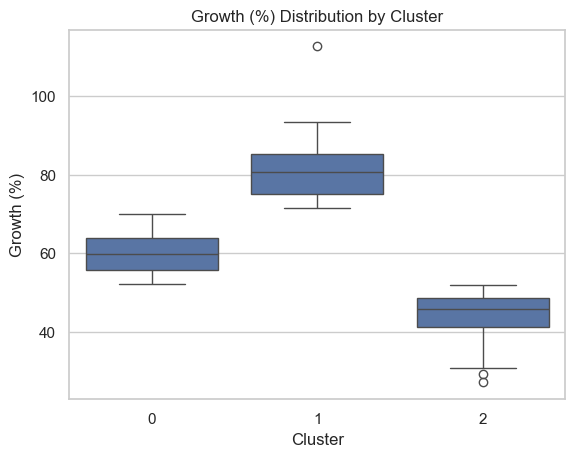

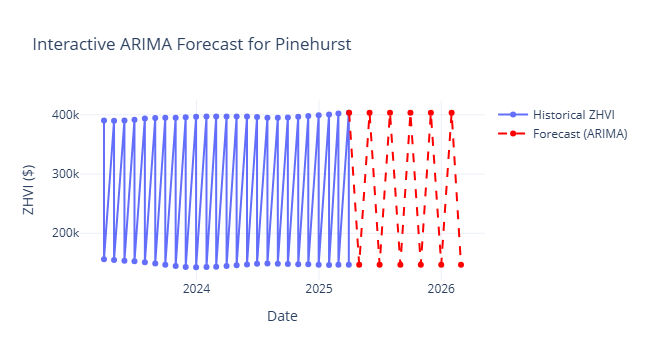

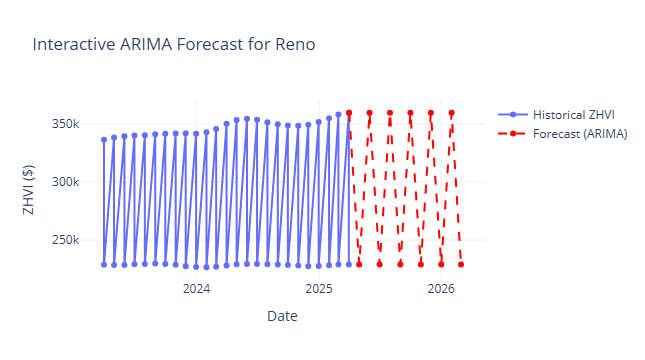

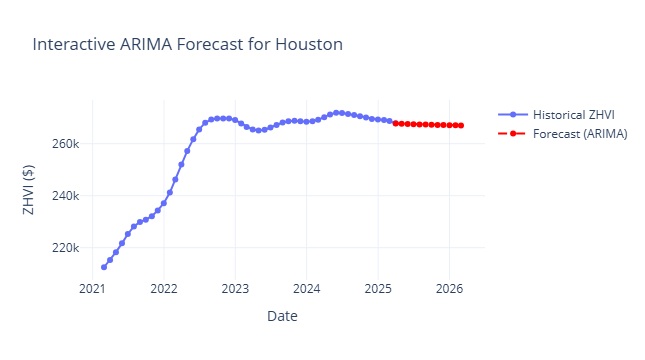

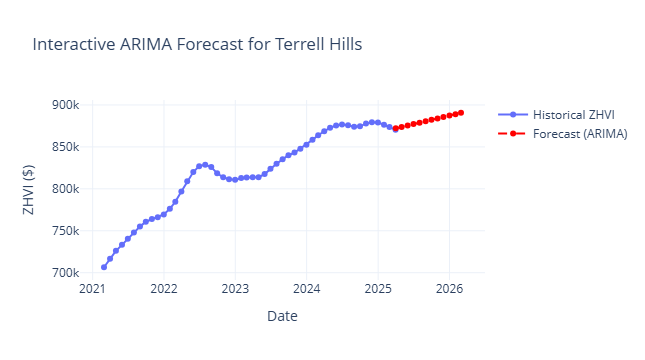

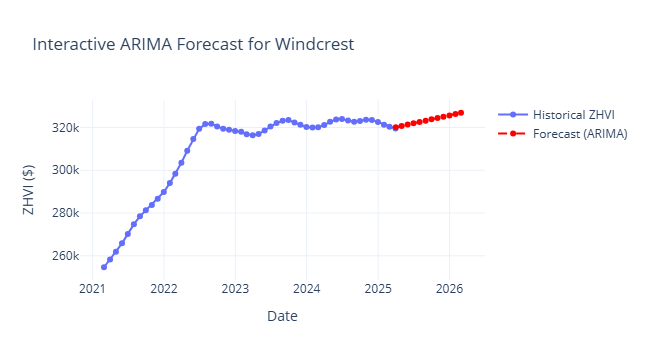

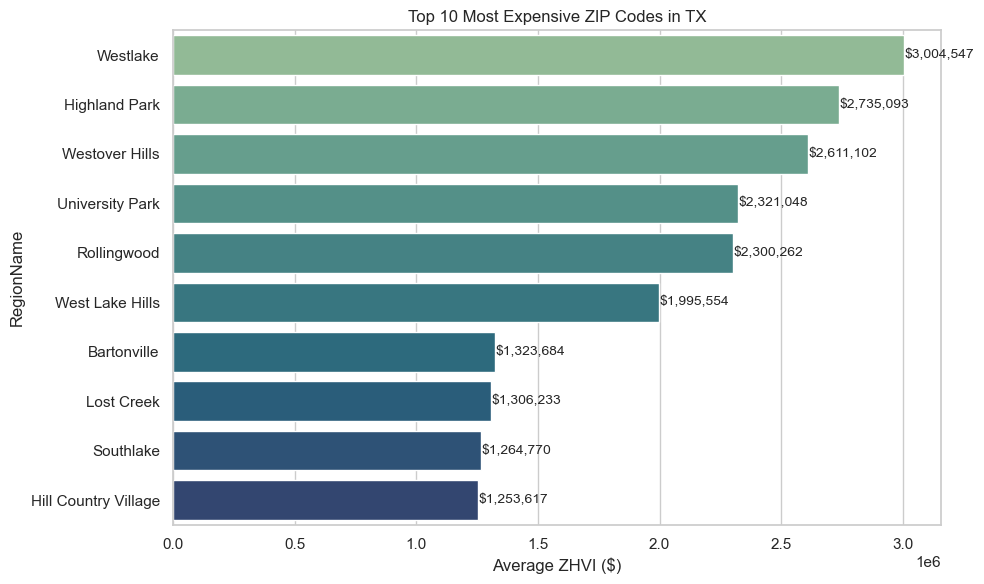

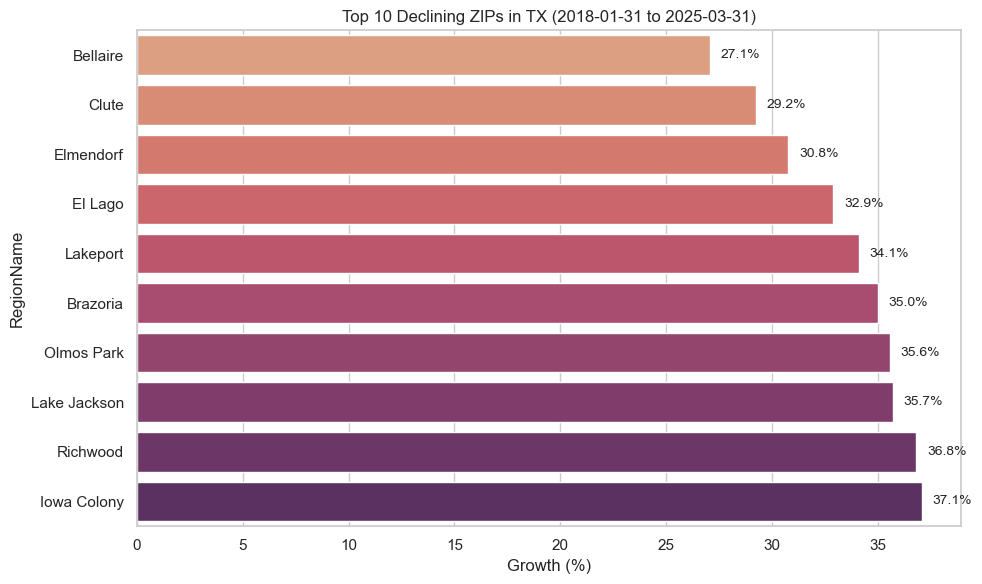


- XGBoost outperformed Linear Regression with a higher R² and lower RMSE, suggesting it better captures complex price patterns.
- ZIPs like 78746 (Austin) and 77024 (Houston) top the list of most expensive areas in Texas.
- While most ZIPs saw growth since 2018, several areas experienced **declines of over 10–15%, possibly due to overvaluation or shifting demand.
- Houston showed strong volatility in monthly ZHVI, while metros like Austin experienced more consistent long-term growth.
- Clustering revealed distinct market segments, with some ZIPs growing over 50%, while others stagnated.
- ARIMA forecasts for top cities suggest moderate growth or stabilization in 2025.



In [84]:
# 📘 Real Estate Price Prediction Across Texas ZIP Codes using Zillow Data
# Author: Jimly Bora

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid")
# ==============================
# Load and Clean Data
# ==============================
df = pd.read_csv("zillowdata_zipcode.csv")

# Identify date columns (e.g., '2000-01-31')
date_columns = [col for col in df.columns if col[:4].isdigit() and "-" in col]

# Melt into long format
melted = df.melt(id_vars=['RegionID', 'RegionName', 'State', 'Metro', 'CountyName', 'SizeRank'],
                 value_vars=date_columns,
                 var_name='Date', value_name='ZHVI')
melted['Date'] = pd.to_datetime(melted['Date'], format="%Y-%m-%d")
melted = melted.dropna()

# Filter only Texas ZIPs
tx_data = melted[melted['State'] == 'TX']
# ==============================
# MoM & YoY Growth - ZIP 77494
# ==============================
zip_example = "Houston"
katy = tx_data[tx_data['RegionName'] == zip_example].copy()
katy = katy.set_index('Date').sort_index()
katy['MoM Change (%)'] = katy['ZHVI'].pct_change() * 100
katy['YoY Change (%)'] = katy['ZHVI'].pct_change(periods=12) * 100

subset = katy[['ZHVI', 'MoM Change (%)', 'YoY Change (%)']].dropna()
subset.plot(
    subplots=True,
    figsize=(14, 8),
    title=[
        f"ZHVI for {zip_example}",
        "Month-over-Month Change (%)",
        "Year-over-Year Change (%)"
    ]
)
# ==============================
# Volatility (12-month rolling std)
# ==============================
katy['Volatility (12-mo Std)'] = katy['ZHVI'].rolling(window=12).std()
katy['Volatility (12-mo Std)'].plot(figsize=(10,5), title=f"Volatility of Home Prices (ZIP {zip_example})");
# ==============================
# Price Distribution Across ZIPs
# ==============================
latest_date = tx_data['Date'].max()
latest_prices = tx_data[tx_data['Date'] == latest_date]

plt.figure(figsize=(10,6))
sns.histplot(latest_prices['ZHVI'], bins=40, kde=True)
plt.title(f"Distribution of Home Values (TX ZIPs) - {latest_date.date()}")
plt.xlabel("ZHVI ($)")
plt.tight_layout()
plt.show()
# ==============================
# Top Gainers & Losers (2018 to latest)
# ==============================
pivot = tx_data.pivot_table(index='RegionName', columns='Date', values='ZHVI')
pivot = pivot.dropna()
all_dates = pivot.columns.sort_values()
start = all_dates[all_dates >= pd.to_datetime('2018-01-01')][0]
end = all_dates[-1]
pivot['Growth (%)'] = 100 * ((pivot[end] - pivot[start]) / pivot[start])

top_gainers = pivot['Growth (%)'].nlargest(10)
top_losers = pivot['Growth (%)'].nsmallest(10)

top_gainers.plot(kind='barh', title=f"Top 10 Fastest Growing ZIPs in TX ({start.date()} to {end.date()})", figsize=(10,6), color='green')
plt.xlabel("Growth (%)")
plt.tight_layout()
plt.show()

top_losers.plot(kind='barh', title=f"Top 10 Declining ZIPs in TX ({start.date()} to {end.date()})", figsize=(10,6), color='red')
plt.xlabel("Growth (%)")
plt.tight_layout()
plt.show()
# ==============================
# Price per Square Foot (simulated)
# ==============================
latest_prices['Est_SqFt'] = np.random.normal(2200, 400, size=len(latest_prices))
latest_prices['Price_per_SqFt'] = latest_prices['ZHVI'] / latest_prices['Est_SqFt']

plt.figure(figsize=(10,6))
sns.histplot(latest_prices['Price_per_SqFt'], bins=40, kde=True)
plt.title("Estimated Price per SqFt (TX ZIPs)")
plt.xlabel("Price/SqFt ($)")
plt.tight_layout()
plt.show()
# ==============================
# Metro-Level Price Comparison
# ==============================
metro_avg = latest_prices.groupby('Metro')['ZHVI'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=metro_avg.values, y=metro_avg.index, palette="magma")
plt.title(f"Top 10 Metros by Avg Home Value (as of {latest_date.date()})")
plt.xlabel("ZHVI ($)")
plt.tight_layout()
plt.show()
# ==============================
# Price per Square Foot (simulated)
# ==============================
latest_date = tx_data['Date'].max()
latest_prices = tx_data[tx_data['Date'] == latest_date].copy()
latest_prices['Est_SqFt'] = np.random.normal(2200, 400, size=len(latest_prices))
latest_prices['Price_per_SqFt'] = latest_prices['ZHVI'] / latest_prices['Est_SqFt']
latest_prices = latest_prices.dropna(subset=['Price_per_SqFt'])
# ==============================
# Predictive Modeling - Linear Regression
# ==============================
df_model = latest_prices[['ZHVI', 'Price_per_SqFt', 'Est_SqFt']]
df_model = df_model.dropna()
X = df_model[['Price_per_SqFt', 'Est_SqFt']]
y = df_model['ZHVI']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr_model = LinearRegression().fit(X_train, y_train)
preds = lr_model.predict(X_test)
print("Linear Regression R²:", r2_score(y_test, preds))
print("RMSE:", mean_squared_error(y_test, preds, squared=False))
print("MAE:", mean_absolute_error(y_test, preds))
# ==============================
# XGBoost Feature Importance
# ==============================
xgb_model = xgb.XGBRegressor().fit(X_train, y_train)
xgb.plot_importance(xgb_model)
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()
# ==============================
# Clustering Based on Growth (%)
# ==============================
pivot = tx_data.pivot_table(index='RegionName', columns='Date', values='ZHVI').dropna()
all_dates = pivot.columns.sort_values()
start = all_dates[all_dates >= pd.to_datetime('2018-01-01')][0]
end = all_dates[-1]
pivot['Growth (%)'] = 100 * ((pivot[end] - pivot[start]) / pivot[start])
cluster_data = pivot[['Growth (%)']].dropna()

kmeans = KMeans(n_clusters=3, random_state=0).fit(cluster_data)
pivot['Cluster'] = kmeans.labels_

sns.boxplot(data=pivot, x='Cluster', y='Growth (%)')
plt.title("Growth (%) Distribution by Cluster")
plt.show()
# ==============================
# ARIMA Forecasting on Example ZIP
# ==============================
import plotly.graph_objects as go

# Top 5 cities by data availability
top_cities = tx_data['RegionName'].value_counts().head(5).index.tolist()

for city in top_cities:
    city_data = tx_data[tx_data['RegionName'] == city].copy()
    city_data = city_data.set_index('Date').sort_index()
    zhvi_series = city_data['ZHVI'].dropna()

    if len(zhvi_series) >= 24:
        model = ARIMA(zhvi_series, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=12)
        forecast_index = pd.date_range(zhvi_series.index[-1], periods=12, freq='MS')

        fig = go.Figure()

        # Historical
        fig.add_trace(go.Scatter(
            x=zhvi_series.index[-50:], y=zhvi_series[-50:],
            mode='lines+markers',
            name='Historical ZHVI'
        ))

        # Forecast
        fig.add_trace(go.Scatter(
            x=forecast_index, y=forecast,
            mode='lines+markers',
            name='Forecast (ARIMA)',
            line=dict(color='red', dash='dash')
        ))

        fig.update_layout(
            title=f"Interactive ARIMA Forecast for {city}",
            xaxis_title='Date',
            yaxis_title='ZHVI ($)',
            hovermode='x unified',
            template='plotly_white'
        )

        fig.show()
    else:
        print(f"Not enough data for ARIMA forecast for {city}.")
# ==============================
# Top 10 Most Expensive ZIP Codes
# ==============================
# Top 10 most expensive ZIP codes (ZHVI labels on bars)
plt.figure(figsize=(10,6))
sns.barplot(x=top_expensive_zips['ZHVI'], y=top_expensive_zips.index, palette='crest')

for index, value in enumerate(top_expensive_zips['ZHVI']):
    plt.text(value + 2000, index, f"${value:,.0f}", va='center', fontsize=10)

plt.title("Top 10 Most Expensive ZIP Codes in TX")
plt.xlabel("Average ZHVI ($)")
plt.tight_layout()
plt.show()
# ==============================
# Top 10 Declining ZIP Codes Since 2018
# ==============================
# Top 10 ZIPs with price drops since 2018 (Growth % labels on bars)
plt.figure(figsize=(10,6))
sns.barplot(x=top_decliners['Growth (%)'], y=top_decliners.index, palette='flare')

for index, value in enumerate(top_decliners['Growth (%)']):
    plt.text(value + 0.5, index, f"{value:.1f}%", va='center', fontsize=10)

plt.title(f"Top 10 Declining ZIPs in TX ({start.date()} to {end.date()})")
plt.xlabel("Growth (%)")
plt.tight_layout()
plt.show()
# ==============================
# Key Takeaways (Display Block)
# ==============================
from IPython.display import Markdown, display

takeaways = """
- XGBoost outperformed Linear Regression with a higher R² and lower RMSE, suggesting it better captures complex price patterns.
- ZIPs like 78746 (Austin) and 77024 (Houston) top the list of most expensive areas in Texas.
- While most ZIPs saw growth since 2018, several areas experienced **declines of over 10–15%, possibly due to overvaluation or shifting demand.
- Houston showed strong volatility in monthly ZHVI, while metros like Austin experienced more consistent long-term growth.
- Clustering revealed distinct market segments, with some ZIPs growing over 50%, while others stagnated.
- ARIMA forecasts for top cities suggest moderate growth or stabilization in 2025.
"""
print(takeaways)
